In [44]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import glob
import sys
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../src')
from clf_parser import CLFParse

In [46]:
# Modify path here for your particular system
data_dir = Path('/Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/rings/rings-apache-metrics')
tools2_logs = sorted(glob.glob(str(data_dir) + "/tools2*"))
server1_logs = sorted(glob.glob(str(data_dir) + "/server1*"))

In [47]:
parser_tools2 = CLFParse(tools2_logs)
parser_server1 = CLFParse(server1_logs)

In [48]:
%%time
# This might take a while. 
parser_tools2.parse_files()

Logfiles list contains 198 files.
10 files have been processed. 0.04 minutes elapsed
20 files have been processed. 0.09 minutes elapsed
30 files have been processed. 0.19 minutes elapsed
40 files have been processed. 0.26 minutes elapsed
50 files have been processed. 0.34 minutes elapsed
60 files have been processed. 0.42 minutes elapsed
70 files have been processed. 0.53 minutes elapsed
80 files have been processed. 0.64 minutes elapsed
90 files have been processed. 0.77 minutes elapsed
100 files have been processed. 0.89 minutes elapsed
110 files have been processed. 0.99 minutes elapsed
120 files have been processed. 1.11 minutes elapsed
130 files have been processed. 1.24 minutes elapsed
140 files have been processed. 1.35 minutes elapsed
150 files have been processed. 1.47 minutes elapsed
160 files have been processed. 1.57 minutes elapsed
170 files have been processed. 1.69 minutes elapsed
180 files have been processed. 1.79 minutes elapsed
190 files have been processed. 1.89 min

In [64]:
parser_tools2.to_file(type="csv", filepath="../datasets/rings_tools2.csv")

Completed creating csv file at ../datasets/rings_tools2.csv.


In [52]:
%%time
# This might take a while. 
parser_server1.parse_files()

Logfiles list contains 197 files.
10 files have been processed. 0.15 minutes elapsed
20 files have been processed. 0.33 minutes elapsed
30 files have been processed. 0.62 minutes elapsed
40 files have been processed. 0.76 minutes elapsed
50 files have been processed. 0.97 minutes elapsed
60 files have been processed. 1.22 minutes elapsed
70 files have been processed. 1.42 minutes elapsed
80 files have been processed. 1.69 minutes elapsed
90 files have been processed. 2.01 minutes elapsed
100 files have been processed. 2.24 minutes elapsed
110 files have been processed. 2.43 minutes elapsed
120 files have been processed. 2.74 minutes elapsed
130 files have been processed. 2.95 minutes elapsed
140 files have been processed. 3.19 minutes elapsed
150 files have been processed. 3.51 minutes elapsed
160 files have been processed. 3.73 minutes elapsed
170 files have been processed. 3.94 minutes elapsed
180 files have been processed. 4.24 minutes elapsed
190 files have been processed. 4.51 min

In [59]:
parser_server1.to_file(type="parquet", filepath="../datasets/rings_server1.pq")

Completed creating parquet file at ../datasets/rings_server1.pq.


## Example Read in File and Create Data Viz


In [61]:
%%time
df_server1 = pd.read_parquet('../datasets/rings_server1.pq')

CPU times: user 1.97 s, sys: 932 ms, total: 2.9 s
Wall time: 3.18 s


In [62]:
df_server1.shape

(3465553, 9)

In [63]:
df_server1.head()

,ip,identd,userid,datetime,request,status,size,referer,user_agent
0,66.249.79.92,None,None,2021-01-01 00:00:12-08:00,GET /pds4/bundles/cassini_vims_saturn/data_raw...,200,88064.0,None,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...
1,66.249.79.92,None,None,2021-01-01 00:00:16-08:00,GET /pds4/bundles/cassini_vims_saturn/data_raw...,200,599040.0,None,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...
2,114.119.138.239,None,None,2021-01-01 00:00:16-08:00,GET /press_releases/pages/PIA08xxx/PIA08204.ht...,200,18417.0,None,Mozilla/5.0 (Linux; Android 7.0;) AppleWebKit/...
3,5.255.253.135,None,None,2021-01-01 00:00:19-08:00,GET /press_releases/pages/PIA18xxx/PIA18360.ht...,200,18711.0,None,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
4,13.66.139.95,None,None,2021-01-01 00:00:52-08:00,GET /saturn/cassini/jpegMod/PIA18271_modest.jp...,200,97957.0,None,Mozilla/5.0 (compatible; bingbot/2.0; +http://...


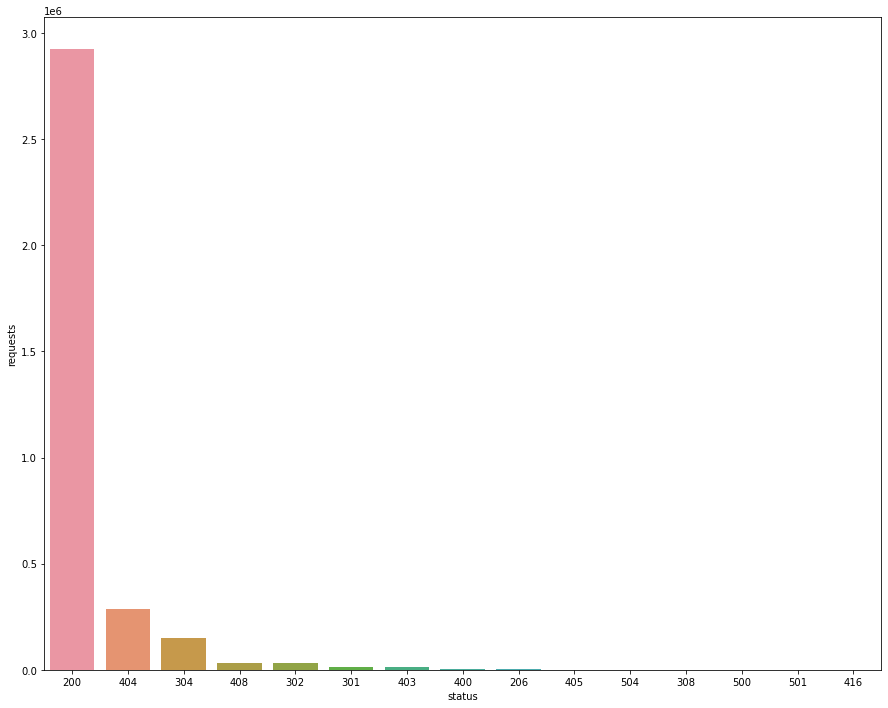

In [58]:
df_summary = (
    df_server1.
    groupby(by='status').
    size().to_frame('requests').reset_index().
    sort_values(by='requests', ascending=False)
)
fig, ax = plt.subplots(figsize=(15, 12))
bar_p = sns.barplot(data=df_summary, x='status', y='requests', 
                    order=df_summary.sort_values('requests', ascending=False).status)

In [38]:
df_summary

,status,requests
0,200,2926924
8,404,287394
4,304,151497
10,408,30605
3,302,30013
2,301,15434
7,403,12951
6,400,5672
1,206,4299
9,405,308


In [39]:
df_server1.shape

(3465553, 10)